#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
!pip install logomaker
!pip install pyBigWig

You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [3]:
import pandas as pd
outstem = 'K562_rep6'
rbp = 'IGF2BP2'
motif = 'TGTA'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                                 'seq', 'struct', 'label', 'start'])

In [4]:
max_length=seq['seq'].str.len().max()

# Evaluate training

In [5]:
# plot training curve
curve = pd.read_csv(f'../data/ABC_data/{outstem}.training_curve.csv')

type
test     AxesSubplot(0.125,0.125;0.775x0.755)
train    AxesSubplot(0.125,0.125;0.775x0.755)
Name: loss, dtype: object

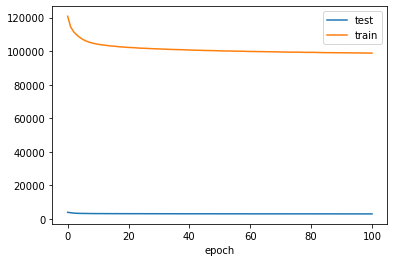

In [6]:
curve.set_index('epoch').groupby(by = 'type')['loss'].plot(legend = True)

# visualize

<AxesSubplot:>

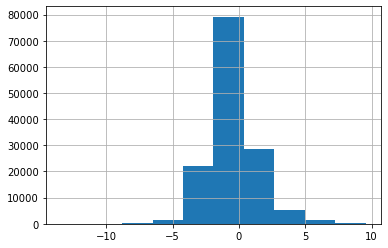

In [7]:
megaoutput[f'logLR:{outstem}.{rbp}'].hist()

In [8]:
positive = megaoutput.loc[megaoutput[f'logLR:{outstem}.{rbp}']>2]

In [9]:
positive['logLR_bin'] = pd.cut(positive[f'logLR:{outstem}.{rbp}'], bins = 5)

/tmp/ipykernel_16284/4225601108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive['logLR_bin'] = pd.cut(positive[f'logLR:{outstem}.{rbp}'], bins = 5)


In [10]:
positive['logLR_bin'].value_counts()

(1.996, 3.514]    7205
(3.514, 5.024]    2501
(5.024, 6.535]    1083
(6.535, 8.045]     340
(8.045, 9.556]      42
Name: logLR_bin, dtype: int64

In [11]:
positive['gene_name'].value_counts().iloc[:20]

RP11-301G19.1    70
CBX5             60
SRRM2            38
BCAT1            38
MAPK1            35
PABPC1           35
PRRC2C           31
NUP214           31
GSE1             31
PRKCB            27
CDK6             26
RP11-706O15.1    25
ANKRD17          24
QSER1            24
POM121           24
PICALM           23
CAPRIN1          22
MAP1B            21
ARID1A           21
EEF2             21
Name: gene_name, dtype: int64

In [13]:
# # only plot specific outputs
# sample_size = 64
# subset = []
# # select specific logLR as outputs
# #subset = megaoutput.loc[megaoutput[f'{outstem}.{rbp}']].sample(sample_size)
# for name,group in positive.groupby(by=['logLR_bin']):
#     try:
#         subset.append(group.sample(sample_size))
#     except:
#         subset.append(group)
# subset = pd.concat(subset, axis = 0)           
# subset[f'logLR:{outstem}.{rbp}'].hist()

In [14]:
subset = positive.loc[positive['feature_type_top']=='UTR3'].sample(64)

In [15]:
from prismnet.utils import datautils

In [16]:
subset_seq_df = seq.set_index('name').loc[subset['name'].tolist(), ['seq']]

In [17]:
subset_seq_df.shape

(64, 1)

In [18]:
one_hot = datautils.convert_one_hot(subset_seq_df['seq'].tolist(), max_length)
one_hot.shape # N, 4, max_length

(64, 4, 100)

In [19]:
data = one_hot

In [20]:
# targets: predict binary
target_col = subset.columns[(subset.columns.str.startswith('logLR'))&(subset.columns.str.contains(outstem))]
target_df = subset[target_col]

In [21]:
targets = target_df.values
targets.shape

(64, 10)

In [22]:
import numpy as np
train, test = datautils.split_dataset(data, targets, valid_frac=0.2)

target_data_type = np.float32

In [23]:
from prismnet.model.PrismNet import *
class PrismNet_Multitask(nn.Module):
    def __init__(self, mode="pu", output_dim=10):
        super(PrismNet_Multitask, self).__init__()
        self.mode = mode
        h_p, h_k = 2, 5 
        if mode=="pu":
            self.n_features = 5
        elif mode=="seq":
            self.n_features = 4
            h_p, h_k = 1, 3 
        elif mode=="str":
            self.n_features = 1
            h_p, h_k = 0, 1
        else:
            raise "mode error"
        
        base_channel = 8
        self.conv    = Conv2d(1, base_channel, kernel_size=(11, h_k), bn = True, same_padding=True)
        self.se      = SEBlock(base_channel)
        self.res2d   = ResidualBlock2D(base_channel, kernel_size=(11, h_k), padding=(5, h_p)) 
        self.res1d   = ResidualBlock1D(base_channel*4) 
        self.avgpool = nn.AvgPool2d((1,self.n_features))
        self.gpool   = nn.AdaptiveAvgPool1d(1)
        self.fc      = nn.Linear(base_channel*4*8, output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, input):
        """[forward]
        
        Args:
            input ([tensor],N,C,W,H): input features
        """
        if self.mode=="seq":
            input = input[:,:,:,:4]
        elif self.mode=="str":
            input = input[:,:,:,4:]
        x = self.conv(input)
        x = F.dropout(x, 0.1, training=self.training)
        z = self.se(x)
        x = self.res2d(x*z)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.avgpool(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.res1d(x)
        x = F.dropout(x, 0.3, training=self.training)
        x = self.gpool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x)
        return x

In [24]:
model = PrismNet_Multitask(mode = 'seq', output_dim = targets.shape[1])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem}.model.pt'))

<All keys matched successfully>

In [25]:
class SeqicSHAPE_Multitask(torch.utils.data.Dataset):
    def __init__(self, X, Y, is_infer=False, use_structure=True):
        """data loader
        
        Args:
            data_path ([str]): h5 file path
            is_test (bool, optional): testset or not. Defaults to False.
        """
        if is_infer:
            self.dataset = self.__load_infer_data__(data_path, use_structure=use_structure)
            print("infer data: ", self.__len__()," use_structure: ", use_structure)
        else:
#             dataset = h5py.File(data_path, 'r')
#             X_train = np.array(dataset['X_train']).astype(np.float32)
#             Y_train = np.array(dataset['Y_train']).astype(np.int32)
#             X_test  = np.array(dataset['X_test']).astype(np.float32)
#             Y_test  = np.array(dataset['Y_test']).astype(np.int32)
            X = np.array(X).astype(np.float32)
            Y = np.array(Y).astype(np.float32)
#             if len(Y_train.shape) == 1:
#                 Y_train = np.expand_dims(Y_train, axis=1)
#                 Y_test  = np.expand_dims(Y_test, axis=1)
            X = np.expand_dims(X, axis=3).transpose([0, 3, 2, 1]) # N, 1, length, channel
            

            

#             labels, nums = np.unique(Y_train,return_counts=True)
#             print("train:", labels, nums)
#             labels, nums = np.unique(Y_test,return_counts=True)
#             print("test:", labels, nums)

#             train = self.__prepare_data__(train)
#             test  = self.__prepare_data__(test)

            
            self.dataset = {'inputs': X, 'targets': Y}
            

        

    def __load_infer_data__(self, data_path, use_structure=True):
        from prismnet.utils import datautils
        dataset = datautils.load_testset_txt(data_path, use_structure=use_structure, seq_length=101)
        return dataset
       
    
    def __prepare_data__(self, data):
        inputs    = data['inputs'][:,:,:,:4]
        structure = data['inputs'][:,:,:,4:]
        structure = np.expand_dims(structure[:,:,:,0], axis=3)
        inputs    = np.concatenate([inputs, structure], axis=3)
        data['inputs']  = inputs
        return data

    def __to_sequence__(self, x):
        x1 = np.zeros_like(x[0,:,:1])
        for i in range(x1.shape[0]):
            # import pdb; pdb.set_trace()
            x1[i] = np.argmax(x[0,i,:4])
            # import pdb; pdb.set_trace()
        return x1

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        x = self.dataset['inputs'][index]
        # x = self.__to_sequence__(x)
        y = self.dataset['targets'][index]
        return x, y


    def __len__(self):
        return len(self.dataset['inputs'])



In [26]:
import numpy as np
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
# train_loader = torch.utils.data.DataLoader(
    
    
#     SeqicSHAPE_Multitask(train[0], train[1], is_infer=False, use_structure=False), 
# batch_size=64, shuffle=True,  **kwargs)

test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(data, targets, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

#print("Train set:", len(train_loader.dataset)) #X_train (example=91099, ATCGshape=5, length=101)
#X_train (example=91099, ATCGshape=5, length=101)
#Y_train (example=91099, binary_outcome=1))
print("Test  set:", len(test_loader.dataset))

Test  set: 64


In [27]:
def train(model, device, train_loader, criterion, optimizer):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    for batch_idx, (x0, y0) in enumerate(train_loader):
        x, y = x0.float().to(device), y0.to(device).float()
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        epoch_loss+=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss
def validate(model, device, test_loader, criterion):
    model.eval()
    y_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (x0, y0) in enumerate(test_loader):
            x, y = x0.float().to(device), y0.to(device).float()
            
            
            output  = model(x)
            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            

    return epoch_loss, y_all

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
nepoch = 60
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
criterion = torch.nn.MSELoss()
batch_size= 64

In [29]:
loss_test, y_test_pred = validate(model, device, test_loader, criterion)

(0.19555833324432542, 0.12147151447502605)


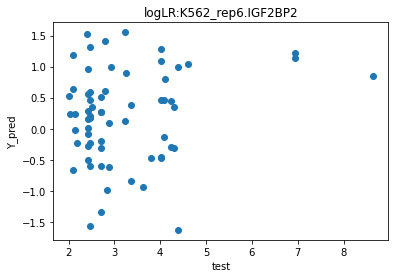

(-0.09707490236252173, 0.445404993836281)


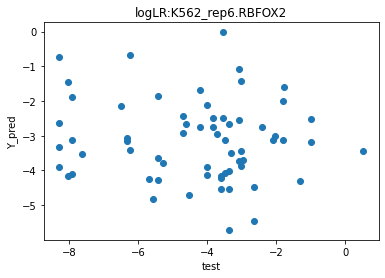

(0.1677282934748301, 0.18524170651142435)


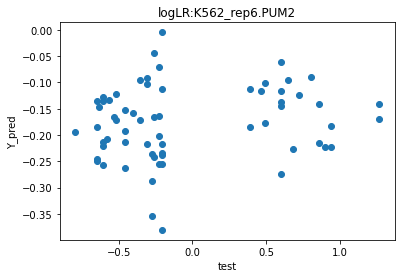

(-0.019070752237457505, 0.8811018103641244)


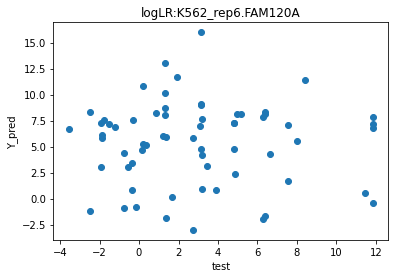

(-0.0302775205466612, 0.812268438905281)


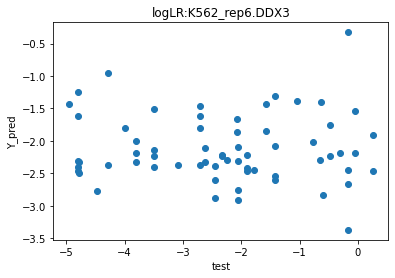

(-0.07876089907731802, 0.5361595740175632)


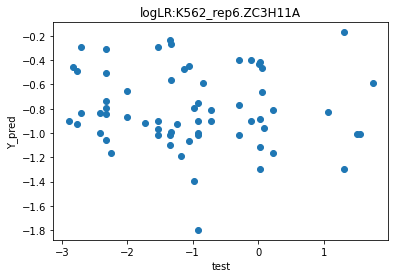

(-0.04517087789467298, 0.7230198269469992)


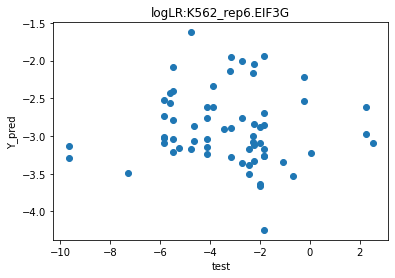

(-0.04866081071619456, 0.7025798229765565)


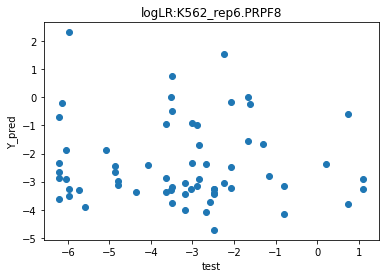

(0.04741421002868887, 0.7098577983191358)


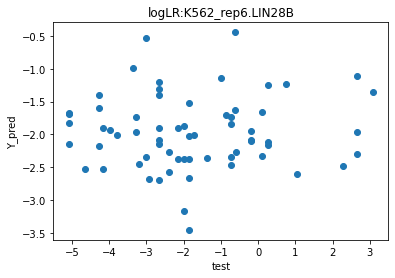

(-0.032104187324257974, 0.8011675136194376)


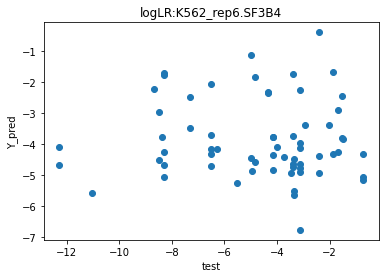

In [30]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
y_pred=np.concatenate(y_test_pred)
for rbp_idx, name in zip(range(test[1].shape[1]), target_df.columns):
    plt.scatter(test[1][:64, rbp_idx], y_pred[:64, rbp_idx])
    plt.ylabel('Y_pred')
    plt.xlabel('test')
    print(pearsonr(test[1][:64, rbp_idx],y_pred[:64, rbp_idx]))
    plt.title(name)
    plt.show()
    

In [31]:
#!/usr/bin/env python
# 
# Kui Xu, xukui.cs@gmail.com
# 2019-02-25
# ref smoothGrad

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad,Variable
import numpy as np

class SmoothGrad(object):
    def __init__(self, model, device='cpu', only_seq=False, train=False, 
        x_stddev=0.015, t_stddev=0.015, nsamples=20, magnitude=2):
        self.model     = model
        self.device    = device
        self.train     = train
        self.only_seq  = only_seq
        self.x_stddev  = x_stddev
        self.t_stddev  = t_stddev
        self.nsamples  = nsamples
        self.magnitude = magnitude
        self.features  = model
        # import pdb; pdb.set_trace()

    def get_gradients(self, z, pred_label=None, rbp_idx = 0):
        self.model.eval()
        self.model.zero_grad()
        z = z.to(self.device)
        z.requires_grad=True
        output = self.model(z)
        
        output[:,rbp_idx].backward() # now it is a multioutput.... maybe sum is not the right way tho!
        return z.grad

    def get_smooth_gradients(self, z, y=None, rbp_idx=0):
        return self.__call__(z, y, rbp_idx = rbp_idx)
        
    def __call__(self, z, y=None,rbp_idx = 0):
        """[summary]
        
        Args:
            z ([type]): [description] X
            y ([type]): [description] Y
            x_stddev (float, optional): [description]. Defaults to 0.15.
            t_stddev (float, optional): [description]. Defaults to 0.15.
            nsamples (int, optional):   [description]. Defaults to 20.
            magnitude (int, optional):  magnitude:0,1,2; 0: original gradient, 1: absolute value of the gradient,
                                        2: square value of the gradient. Defaults to 2.
        
        Returns:
            [type]: [description]
        """

        # 1. for sequece
        x = z[:,:,:,:4] # .data.cpu()
        x_stddev   = (self.x_stddev * (x.max()-x.min())).to(self.device).item() 

        total_grad = torch.zeros(z.shape).to(self.device)
        x_noise    = torch.zeros(x.shape).to(self.device)
        if not self.only_seq:
            # 2. for structure  
            t = z[:,:,:,4:] #.data.cpu()
            t_stddev = (self.t_stddev * (t.max()-t.min())).to(self.device).item() 
            #t_total_grad = torch.zeros(t.shape)
            t_noise = torch.zeros(t.shape).to(self.device)

        for i in range(self.nsamples):
            x_plus_noise = x + x_noise.zero_().normal_(0, x_stddev)
            if self.only_seq:
                z_plus_noise = x_plus_noise
            else:
                t_plus_noise = t + t_noise.zero_().normal_(0, t_stddev)
                z_plus_noise = torch.cat((x_plus_noise, t_plus_noise), dim=3)
            #print("z_plus_noise:",z_plus_noise.size())
            grad = self.get_gradients(z_plus_noise, y, rbp_idx = rbp_idx)
            if self.magnitude == 1:
                total_grad += torch.abs(grad)
            elif self.magnitude == 2:
                total_grad += grad * grad
            
            # total_grad += grad * grad
        total_grad /= self.nsamples
        return total_grad

    def get_batch_gradients(self, X, Y=None, rbp_idx = 0):
        if Y is not None:
            assert len(X) == len(Y), "The size of input {} and target {} are not matched.".format(len(X), len(Y))
        g = torch.zeros_like(X)
        for i in range(X.shape[0]):
            x        = X[i:i+1]
            if Y is not None:
                y    = Y[i:i+1]
            else:
                y    = None
            g[i:i+1] =  self.get_smooth_gradients(x, y, rbp_idx = rbp_idx)
            # g[i:i+1] =  self.get_gradients(x, y)
        return g


def generate_saliency(model, x, y=None, smooth=False, nsamples=2, stddev=0.15, only_seq=False, \
    train=False):
    saliency = SmoothGrad(model, only_seq, train)
    x_grad   = saliency.get_smooth_gradients(x, y, nsamples=nsamples, x_stddev=stddev, t_stddev=stddev)
    return x_grad



class GuidedBackpropReLU(torch.autograd.Function):

    def __init__(self, inplace=False):
        super(GuidedBackpropReLU, self).__init__()
        self.inplace = inplace

    def forward(self, input):
        pos_mask = (input > 0).type_as(input)
        output = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            input,
            pos_mask)
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors

        pos_mask_1 = (input > 0).type_as(grad_output)
        pos_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            torch.addcmul(
                torch.zeros(input.size()).type_as(input), grad_output, pos_mask_1),
                pos_mask_2)

        return grad_input

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + inplace_str + ')'

class GuidedBackpropSmoothGrad(SmoothGrad):

    def __init__(self, model, device='cpu', only_seq=False, train=False, 
        x_stddev=0.15, t_stddev=0.15, nsamples=20, magnitude=2):
        super(GuidedBackpropSmoothGrad, self).__init__(
            model, device, only_seq, train, x_stddev, t_stddev, nsamples, magnitude)
        for idx, module in self.features._modules.items():
            if module.__class__.__name__ is 'ReLU':
                self.features._modules[idx] = GuidedBackpropReLU()



<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_16284/2063606002.py:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if module.__class__.__name__ is 'ReLU':


In [32]:

model.eval()
sgrad = GuidedBackpropSmoothGrad(model, device=device, only_seq = True)

In [34]:
rbp_idx=np.where(target_col.str.contains(rbp))[0][0]
gs = []
for batch_idx, (x0, y0) in enumerate(test_loader):
    X, Y = x0.float().to(device), y0.to(device).float()
    output = model(X)
    
    guided_saliency = sgrad.get_batch_gradients(X, Y, rbp_idx = rbp_idx)
    gs.append(guided_saliency)
gs = torch.cat(gs, axis = 0)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [35]:
gs.shape

torch.Size([64, 1, 100, 4])

In [36]:
# dot product of sequence and guided saliency
max_saliency = (np.transpose(np.expand_dims(one_hot, axis =1), (0,1,3,2))*gs.cpu().numpy()
               ).sum(axis = -1).max(axis = -1).squeeze(-1)

In [37]:
subset_seq_df['is_motif']=subset_seq_df['seq'].str.contains(motif)
subset_seq_df['n_motif']=subset_seq_df['seq'].str.count(motif)
subset_seq_df['max_saliency'] = max_saliency
subset_seq_df[f'logLR:{outstem}.{rbp}'] = subset.set_index('name')[f'logLR:{outstem}.{rbp}']
subset_seq_df['rbp_idx'] = np.arange(subset_seq_df.shape[0])

In [38]:
subset_seq_df.index.tolist()==subset['name'].tolist()

True

array([<AxesSubplot:title={'center':'max_saliency'}, xlabel='is_motif'>,
       <AxesSubplot:title={'center':'logLR:K562_rep6.IGF2BP2'}, xlabel='is_motif'>],
      dtype=object)

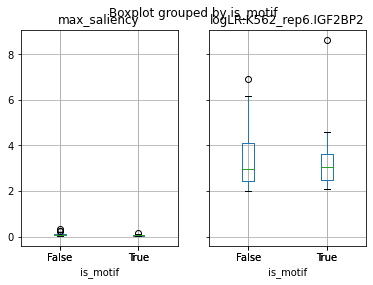

In [39]:
subset_seq_df.boxplot(by = 'is_motif', column = ['max_saliency', f'logLR:{outstem}.{rbp}'])

In [40]:
subset_seq_df.loc[(subset_seq_df['is_motif'])].sort_values(by = 'n_motif')

,seq,is_motif,n_motif,max_saliency,logLR:K562_rep6.IGF2BP2,rbp_idx
name,,,,,,
257407,AAAGCAGCCACAGTTATGTAGGTCTGATTTGAATGTCATAATTGCA...,True,1,0.050491,2.877981,2
1240135,GTTTTATGCTCTTTTTTACTCATTGAAATGTCACGTACTGTCTGAT...,True,1,0.062634,4.007982,60
3685113,TTTCCCTTCTTAGGTTGTTAGTCATTAGTTTGTGTGTGTGTGTGGT...,True,1,0.045706,3.238003,58
191211,GTCTAGATTGTAGCAAATGATGGTACATATTCACAACAAAGTTGTG...,True,1,0.077532,3.238003,57
5260902,TACTTAAACCCCAGATTTTCTACACAGGGCACTTGCTTGAGCCTCA...,True,1,0.076052,4.007982,56
2107845,TGTTGGTAAATGAGTCACTCTAGCATTTGTAGAAGGCTCCCTGAGA...,True,1,0.037555,2.295183,49
4019688,ACTTCATTGGATTAATCAGCTGGTTTCAACTCTACTGCGAAACAAA...,True,1,0.074825,8.643532,39
3977808,AGCTTCTATGGTTTCTTCTAATTCTTATTGCTTAAAGTATGAGTAT...,True,1,0.038003,2.915779,35
5285969,TGTATGCCCACAGCTACTGGAATCCCCGCTGCTGCTCCGGGCCAAG...,True,1,0.035898,2.089314,32


In [41]:
subset_seq_df = subset_seq_df.merge(megaoutput[['name','gene_name', 'feature_type_top', 'start']], left_index = True,
                    right_on = 'name')

In [42]:
import pyBigWig
import numpy as np

class strand_specific_wig:
    def __init__(self, plus, minus):
        self.plus = pyBigWig.open(plus)
        self.minus = pyBigWig.open(minus)
        
    def fetch(self, chrom = None, start= None, end=None, strand= None, interval = None):
        ''' return icSHAPE reacitivity for a bedtool interval or chrom, start, end, strand'''
        if interval:
            start = interval.start
            end = interval.end
            strand = interval.strand
            chrom = interval.chrom
        if strand == '-':
            icshape_data = self.minus
        else:
            icshape_data = self.plus
        values = icshape_data.values(chrom, start, end)
        if strand == '-':
            values = values[::-1]
        return np.nan_to_num(np.array(values), 0)

In [43]:
rbp_wig_cits = strand_specific_wig(f'../data/CITS/{rbp}.pos.bw',
                                 f'../data/CITS/{rbp}.neg.bw'
                                 )
rbp_wig_cov = strand_specific_wig(f'../data/COV/{rbp}.pos.bw',
                             f'../data/COV/{rbp}.neg.bw'
                             )

In [44]:
import seaborn as sns
import logomaker
from scipy.ndimage import gaussian_filter1d

def plot_saliency(index):
    index2seq = 'ACGU'
    

    # find coverage
    window_name = subset_seq_df.loc[subset_seq_df['rbp_idx']==index, 'name'].values[0]
    row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
    wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
    wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])

    seq_values = one_hot[index,:,:] # [1,4,100]
    gradient_values = gs[index,0,:,:].cpu().numpy() # [1,1,100,4]
    saliency_values = gradient_values * seq_values.T # 4*100
    saliency_df = pd.DataFrame(saliency_values.T)
    saliency_df.index = list(index2seq)

    saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
    saliency_df.index = np.arange(saliency_df.shape[0])

    f, ax = plt.subplots(2,1, sharex = True, figsize = (12,4))
    logomaker.Logo(saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('saliency')
    ax[1].bar(np.arange(len(wig_values)), wig_values, color = 'lightgrey')
    ax[1].set_ylabel('coverage')
#     ax[2].bar(np.arange(len(wig_values_cits)), wig_values_cits, color = 'lightgrey')
#     ax[2].plot(gaussian_filter1d(wig_values_cits, 3), color = 'tomato', label = 'smoothed CITS')
#     ax[2].set_ylabel('#CITS')

    ax[0].set_title(row['chrom'] + ':'+str(row['start'])+'-'+str(row['end'])+':'+row['strand'])
    sns.despine()

In [48]:
subset_seq_df.sort_values(by = 'max_saliency')

,seq,is_motif,n_motif,max_saliency,logLR:K562_rep6.IGF2BP2,rbp_idx,name,gene_name,feature_type_top,start
84645,GCATTTATAGAGAAGGATATTTTGTAGTAGTATAGTAATGTGTTAT...,True,3,0.023445,2.190730,50,4608729,BTBD1,UTR3,83017389
79582,GAGAAGGGAGAGGAATGAATTGAGGAAGTGAAAGAAGGCAAGGAGG...,False,0,0.024597,5.903646,33,438895,RAB13,UTR3,153981828
17962,ATTTCTGGAAGAAAATTTAATCTGGCAATATAGACTAATACTCGTT...,False,0,0.025565,2.712485,18,1881508,G3BP1,UTR3,151805334
120919,TCCTGACTTTGGACAAGGCCCTTCAGCCAGAAGACTGACAAAGTCA...,False,0,0.029471,4.007982,0,5568672,CSTB,UTR3,43774117
110052,CTGGGGATGGGGTCATCCCAGGGCTGCCTCCCTCCAGCCCACTGCC...,False,0,0.030713,2.279930,41,5273406,HNRNPUL1,UTR3,41306659
...,...,...,...,...,...,...,...,...,...,...
71947,TTATCCATTCCTTTTGGCCCTGCAGCATGTCATGCTCCCAGAATTT...,False,0,0.199262,6.176856,26,3945971,TUBA1B,UTR3,49127869
72653,GAGGCAGCTGGCATAAAACATTTCTTTCACTTTCCTTTCCCACTCA...,False,0,0.199290,4.304690,51,3959531,NEMP1,UTR3,57057021
42723,TTTTGCAGGTGAAGTCAGCAGCTTAAAAATGTCTTTCCCAGATTTC...,False,0,0.247902,2.519688,12,2794634,LYN,UTR3,56010605
76731,TGAGCATTCTCCACCCATCCCCTGGAAGGAGAGAAATCAAAAACCC...,False,0,0.251932,2.402936,24,4220980,ARF6,UTR3,49894264


findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


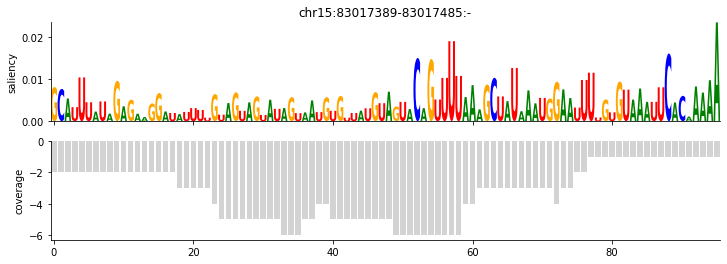

In [49]:
plot_saliency(50)

In [50]:
def plot_saliency(indices):
    index2seq = 'ACGU'
    

    # find coverage
    all_wig_value = []
    all_saliency_values = []
    window_names = subset_seq_df.loc[subset_seq_df['rbp_idx'].isin(indices), 'name']
    sub = megaoutput.loc[megaoutput['name'].isin(window_names)].iloc[0]
    for index in indices:
        window_name = subset_seq_df.loc[subset_seq_df['rbp_idx']==index, 'name'].values[0]
        row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
        wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
        wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])

        seq_values = one_hot[index,:,:] # [1,4,100]
        gradient_values = gs[index,0,:,:].cpu().numpy() # [1,1,100,4]
        saliency_values = gradient_values * seq_values.T # 4*100
        saliency_df = pd.DataFrame(saliency_values.T)
        saliency_df.index = list(index2seq)

        saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
        saliency_df.index = np.arange(saliency_df.shape[0])
        
        all_wig_value.append(wig_values)
        all_saliency_values.append(saliency_df)
        
    
    all_wig_value = np.concatenate(all_wig_value)
    all_saliency_df = pd.concat(all_saliency_values, axis = 0, ignore_index = True)
    print(all_saliency_df)
    
    f, ax = plt.subplots(2,1, sharex = True, figsize = (60,4))
    logomaker.Logo(all_saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('saliency')
    ax[1].bar(np.arange(len(all_wig_value)), all_wig_value, color = 'lightgrey')
    ax[1].set_ylabel('coverage')
    

    ax[0].set_title(row['chrom'] + ':'+str(sub['start'].min())+'-'+str(sub['end'].max())+':'+row['strand'])
    sns.despine()

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plot_saliency([772,773,774,775])
plt.suptitle('NORAD')
plt.savefig('NORAD_PUM2.pdf')